# Shaved head rising confirm pattern - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-10-21 14:10:00,1927.5,1933.0,1918.7,1922.0,16658
2025-10-21 14:15:00,1922.0,1927.5,1919.2,1921.5,8361
2025-10-21 14:20:00,1921.5,1926.0,1902.9,1906.7,16009


In [6]:
data["fit"] = ((data["Close"].shift(1) > data["Open"].shift(1)) & (data["Close"] > data["Open"]) & (data["Close"] == data["High"]) & (data["Close"] > data["High"].shift(1)))

### Calculate Risk & Reward

In [9]:
%%time
data['risk'] = None
data['reward'] = None
for i, row in data.iterrows():
    if row['fit'] == True:
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        max_price = entry_price
        min_price = entry_price
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < min_price:
                min_price = wrow['Low']
            if wrow['High'] > max_price:
                max_price = wrow['High']
            # Long
            risk = entry_price - min_price
            reward = max_price - entry_price
        data.at[i, 'risk'] = risk
        data.at[i, 'reward'] = reward

CPU times: user 8.2 s, sys: 6.88 ms, total: 8.21 s
Wall time: 8.24 s


### Phân tích mối quan hệ Risk/Reward

In [46]:
df6 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df6["risk"] = df6["risk"].astype(float)
df6["reward"] = df6["reward"].astype(float)
df6.dropna(inplace=True)
df6_fit = df6[df6.fit==True]

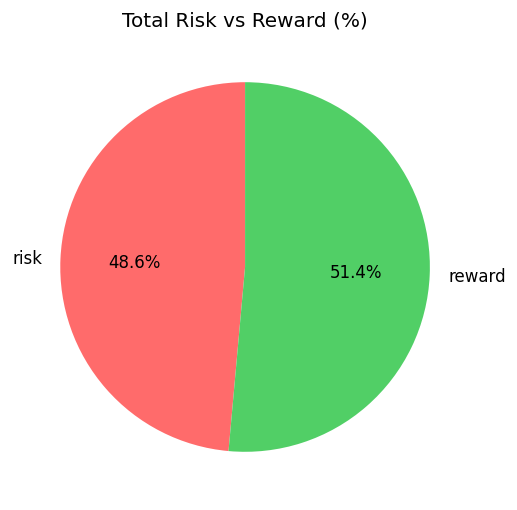

In [47]:
sum_values = df6_fit[["risk", "reward"]].sum()

plt.figure(figsize=(5, 5))
plt.pie(
    sum_values,
    labels=sum_values.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#FF6B6B", "#51CF66"]
)
plt.title("Total Risk vs Reward (%)")
plt.show()

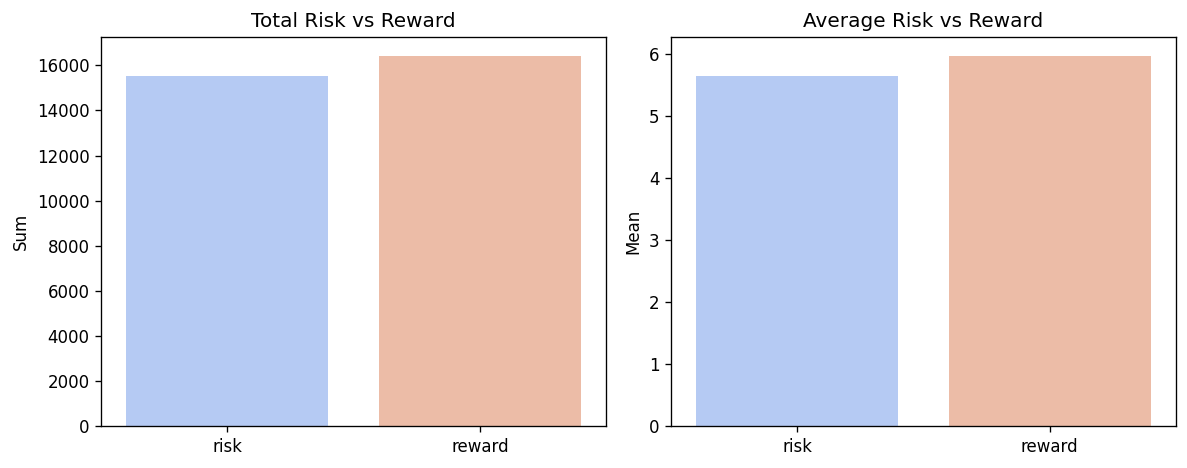

In [48]:
sum_df = df6_fit[["risk", "reward"]].sum().reset_index(name="value")
mean_df = df6_fit[["risk", "reward"]].mean().reset_index(name="value")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=sum_df, x="index", y="value", ax=axes[0], palette="coolwarm")
axes[0].set_title("Total Risk vs Reward")
axes[0].set_xlabel("")
axes[0].set_ylabel("Sum")

sns.barplot(data=mean_df, x="index", y="value", ax=axes[1], palette="coolwarm")
axes[1].set_title("Average Risk vs Reward")
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean")

plt.tight_layout()
plt.show()

### Phân tích mối quan hệ Risk/Reward và Khoảng cách từ giá Close tới EMA20 và EMA250

In [43]:
df5 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df5["risk"] = df5["risk"].astype(float)
df5["reward"] = df5["reward"].astype(float)
df5["return"] = df5["reward"] - df5["risk"]
df5["ema_fast"] = ta.ema(df5["Close"], length=20)
df5["ema_low"] = ta.ema(df5["Close"], length=250)
df5['dist_to_ema20'] = df5["Close"] - df5["ema_fast"]
df5['dist_to_ema250'] = df5["Close"] - df5["ema_low"]
df5['ema20_group'] = pd.qcut(df5.dist_to_ema20, 20)
df5['ema250_group'] = pd.qcut(df5.dist_to_ema250, 20)
df5.dropna(inplace=True)
df5_fit = df5[df5.fit==True]
long_risk = df5_fit.groupby(['ema20_group', 'ema250_group'])[['risk']]
long_reward = df5_fit.groupby(['ema20_group', 'ema250_group'])[['reward']]
long_return = df5_fit.groupby(['ema20_group', 'ema250_group'])[['return']]

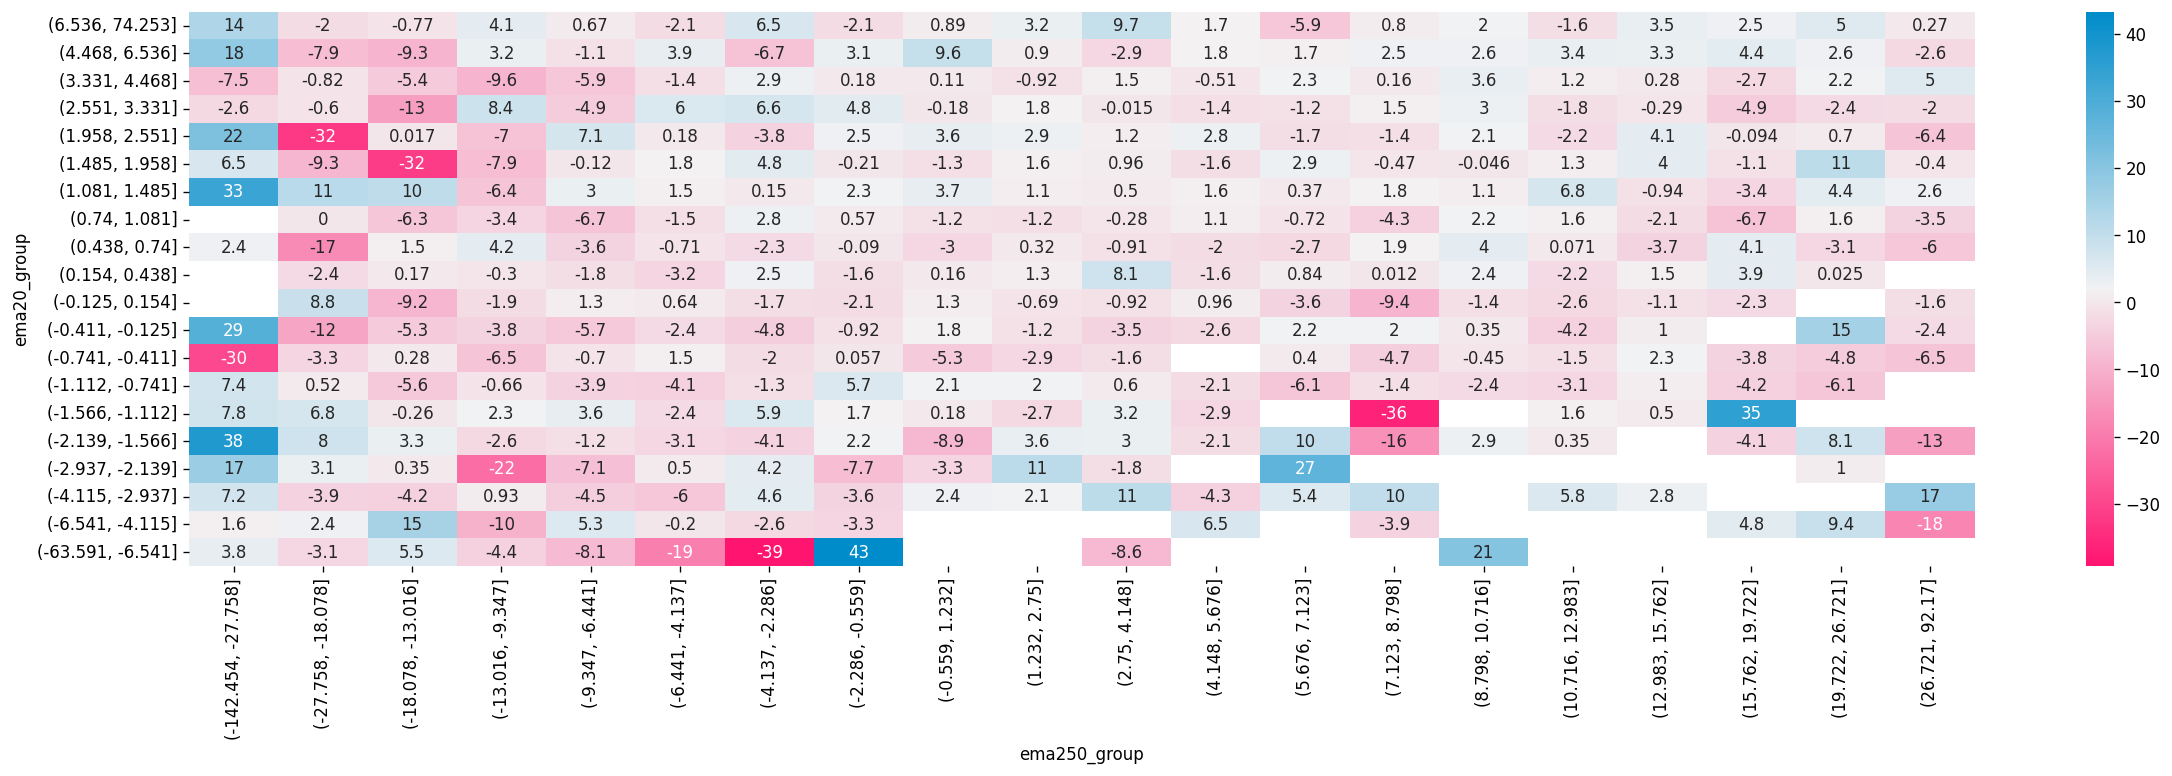

In [45]:
irs = long_return.mean().reset_index()
irs_pivot = irs.pivot(index='ema20_group', columns='ema250_group', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="light", as_cmap=True),
    annot=True);

### Phân tích mối quan hệ Risk/Reward và Min 5 và Max 20 cây nến gần nhất

In [41]:
df4 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df4["risk"] = df4["risk"].astype(float)
df4["reward"] = df4["reward"].astype(float)
df4["return"] = df4["reward"] - df4["risk"]
df4['dist_to_min5'] = df4["Close"] - df4["Low"].rolling(5).min()
df4['dist_to_max20'] = df4["High"].rolling(20).max() - df4["Close"]
df4['min5_group'] = pd.qcut(df4.dist_to_min5, 20)
df4['max20_group'] = pd.qcut(df4.dist_to_max20, 20)
df4.dropna(inplace=True)
df4_fit = df4[df4.fit==True]
long_risk = df4_fit.groupby(['min5_group', 'max20_group'])[['risk']]
long_reward = df4_fit.groupby(['min5_group', 'max20_group'])[['reward']]
long_return = df4_fit.groupby(['min5_group', 'max20_group'])[['return']]

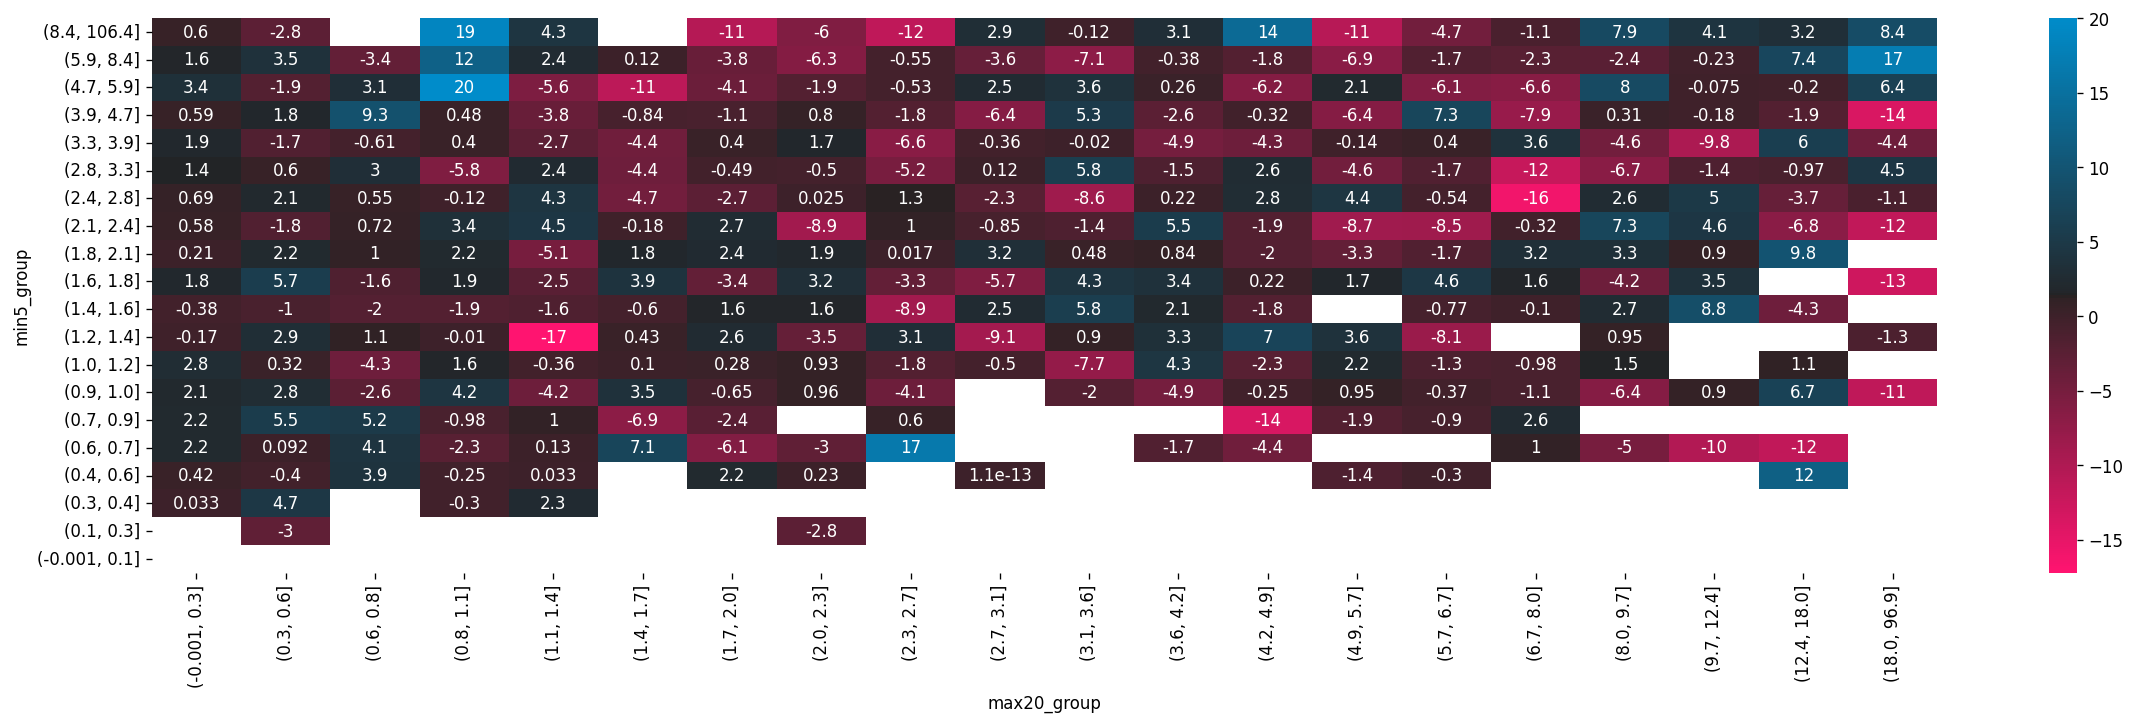

In [42]:
irs = long_return.mean().reset_index()
irs_pivot = irs.pivot(index='min5_group', columns='max20_group', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

### Phân tích mối quan hệ Risk/Reward và Min 3 và Min 10 cây nến gần nhất

In [38]:
df3 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df3["risk"] = df3["risk"].astype(float)
df3["reward"] = df3["reward"].astype(float)
df3["return"] = df3["reward"] - df3["risk"]
df3['dist_to_min3'] = df3["Close"] - df3["Low"].rolling(3).min()
df3['dist_to_min10'] = df3["Close"] - df3["Low"].rolling(10).min()
df3['min3_group'] = pd.qcut(df3.dist_to_min3, 20)
df3['min10_group'] = pd.qcut(df3.dist_to_min10, 20)
df3.dropna(inplace=True)
df3_fit = df3[df3.fit==True]
long_risk = df3_fit.groupby(['min3_group', 'min10_group'])[['risk']]
long_reward = df3_fit.groupby(['min3_group', 'min10_group'])[['reward']]
long_return = df3_fit.groupby(['min3_group', 'min10_group'])[['return']]

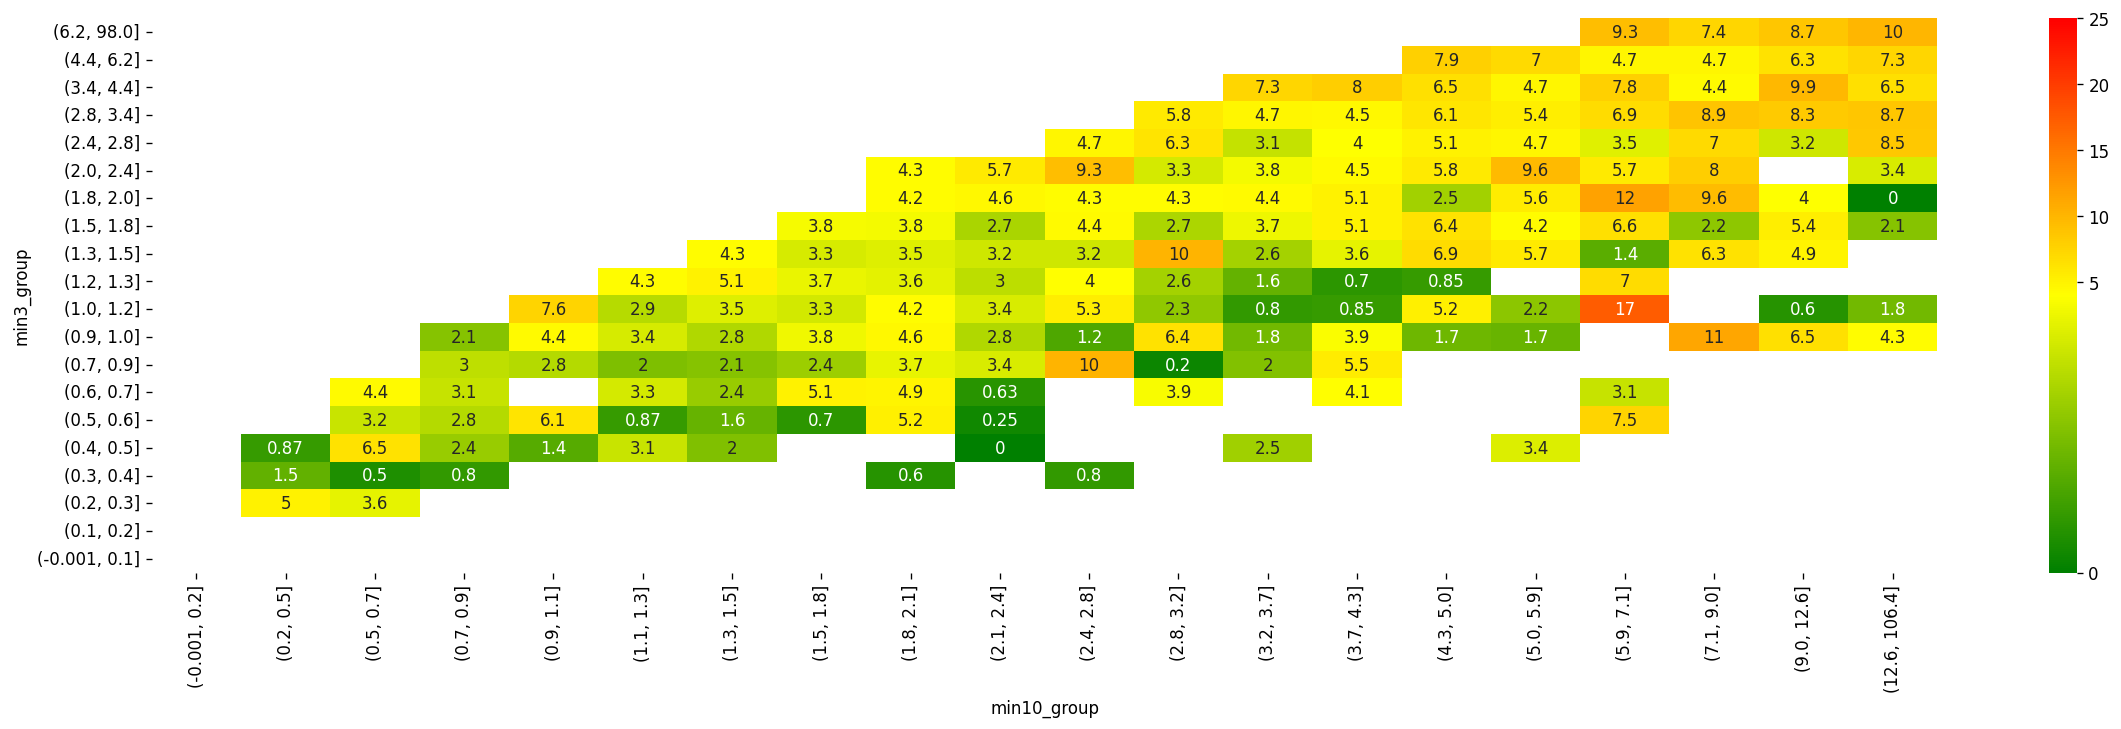

In [39]:
irs1 = long_risk.mean().reset_index()
irs_pivot1 = irs1.pivot(index='min3_group', columns='min10_group', values='risk').sort_index(ascending=False)
sns.heatmap(
    irs_pivot1,
    cmap=LinearSegmentedColormap.from_list("green_to_red", ["green", "yellow", "red"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=25),
    annot=True);

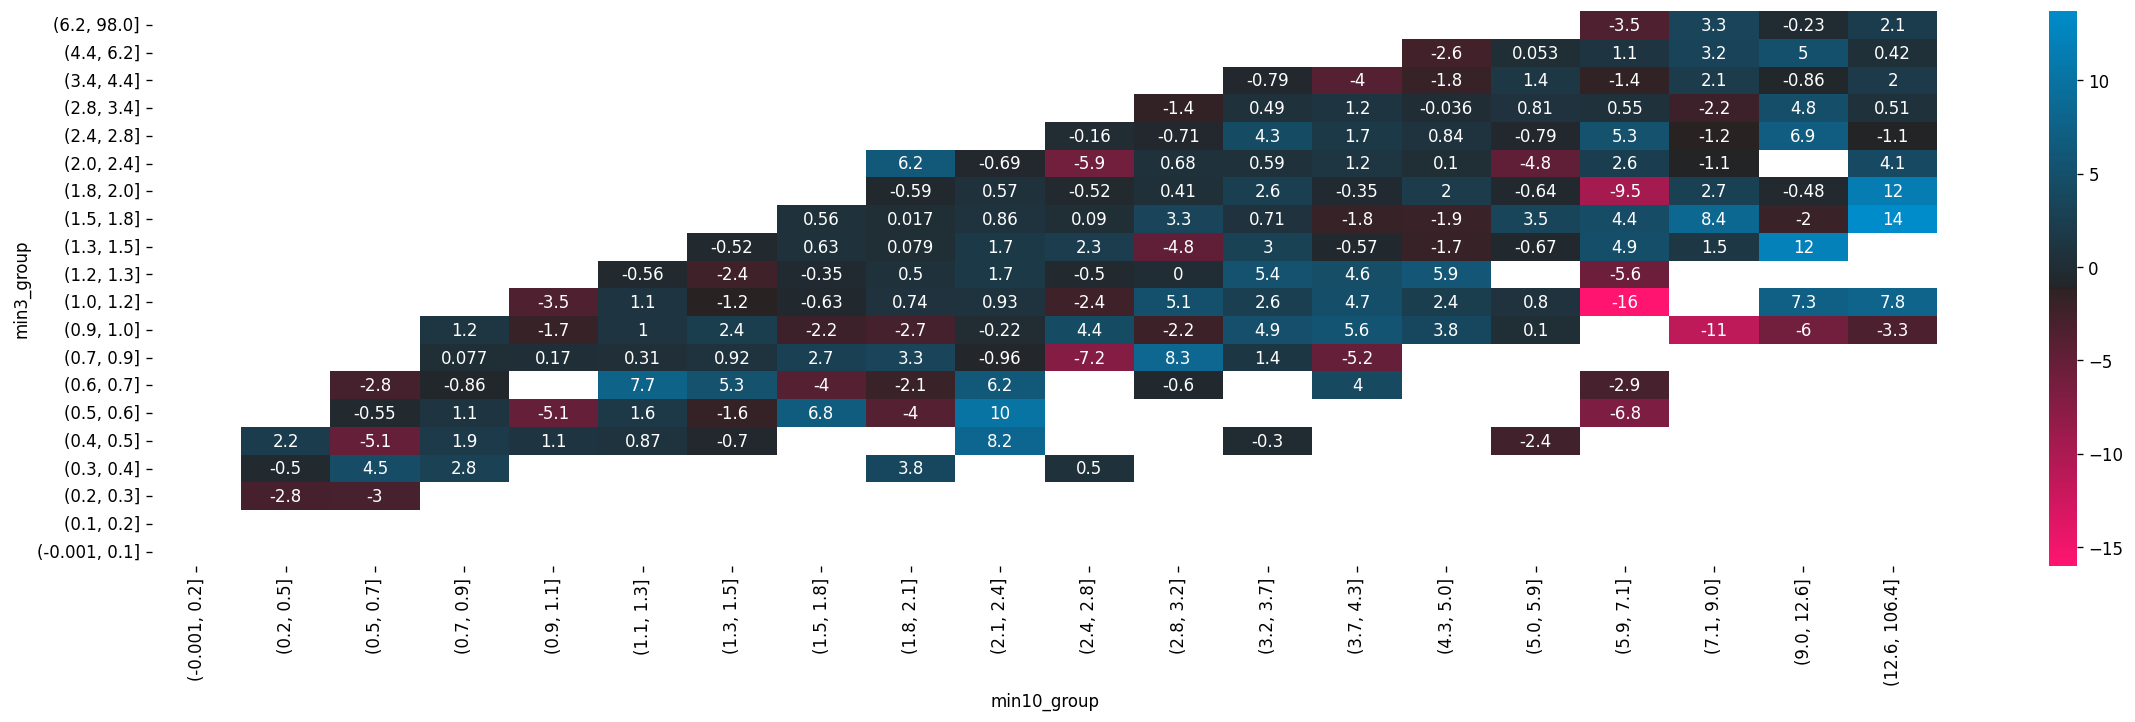

In [40]:
irs2 = long_return.mean().reset_index()
irs_pivot2 = irs2.pivot(index='min3_group', columns='min10_group', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot2,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

### Phân tích mối quan hệ Risk/Reward và Day & Hour

In [19]:
df2 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df2["risk"] = df2["risk"].astype(float)
df2["reward"] = df2["reward"].astype(float)
df2["return"] = df2["reward"] - df2["risk"]
df2['day'] = df2.index.day
df2['hour'] = df2.index.hour
df2.dropna(inplace=True)

In [20]:
df2_fit = df2[df2.fit==True]
long_risk = df2_fit.groupby(['day', 'hour'])[['risk']]
long_reward = df2_fit.groupby(['day', 'hour'])[['reward']]
long_return = df2_fit.groupby(['day', 'hour'])[['return']]

In [31]:
plt.rcParams['figure.figsize'] = [24, 6]
plt.rcParams['figure.dpi'] = 120

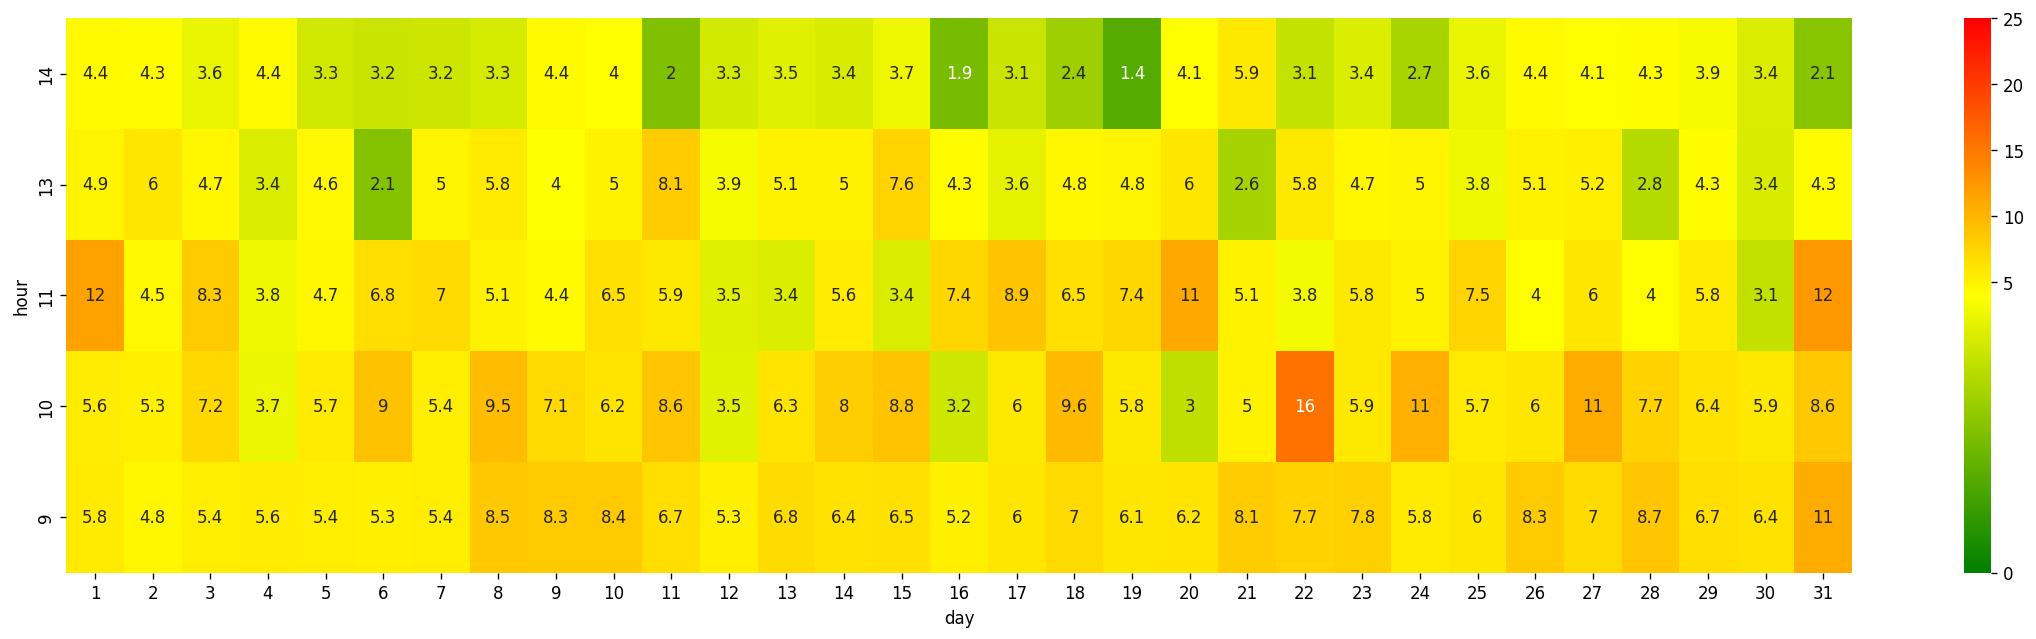

In [28]:
irs1 = long_risk.mean().reset_index()
irs_pivot1 = irs1.pivot(index='hour', columns='day', values='risk').sort_index(ascending=False)
sns.heatmap(
    irs_pivot1,
    cmap=LinearSegmentedColormap.from_list("green_to_red", ["green", "yellow", "red"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=25),
    annot=True);

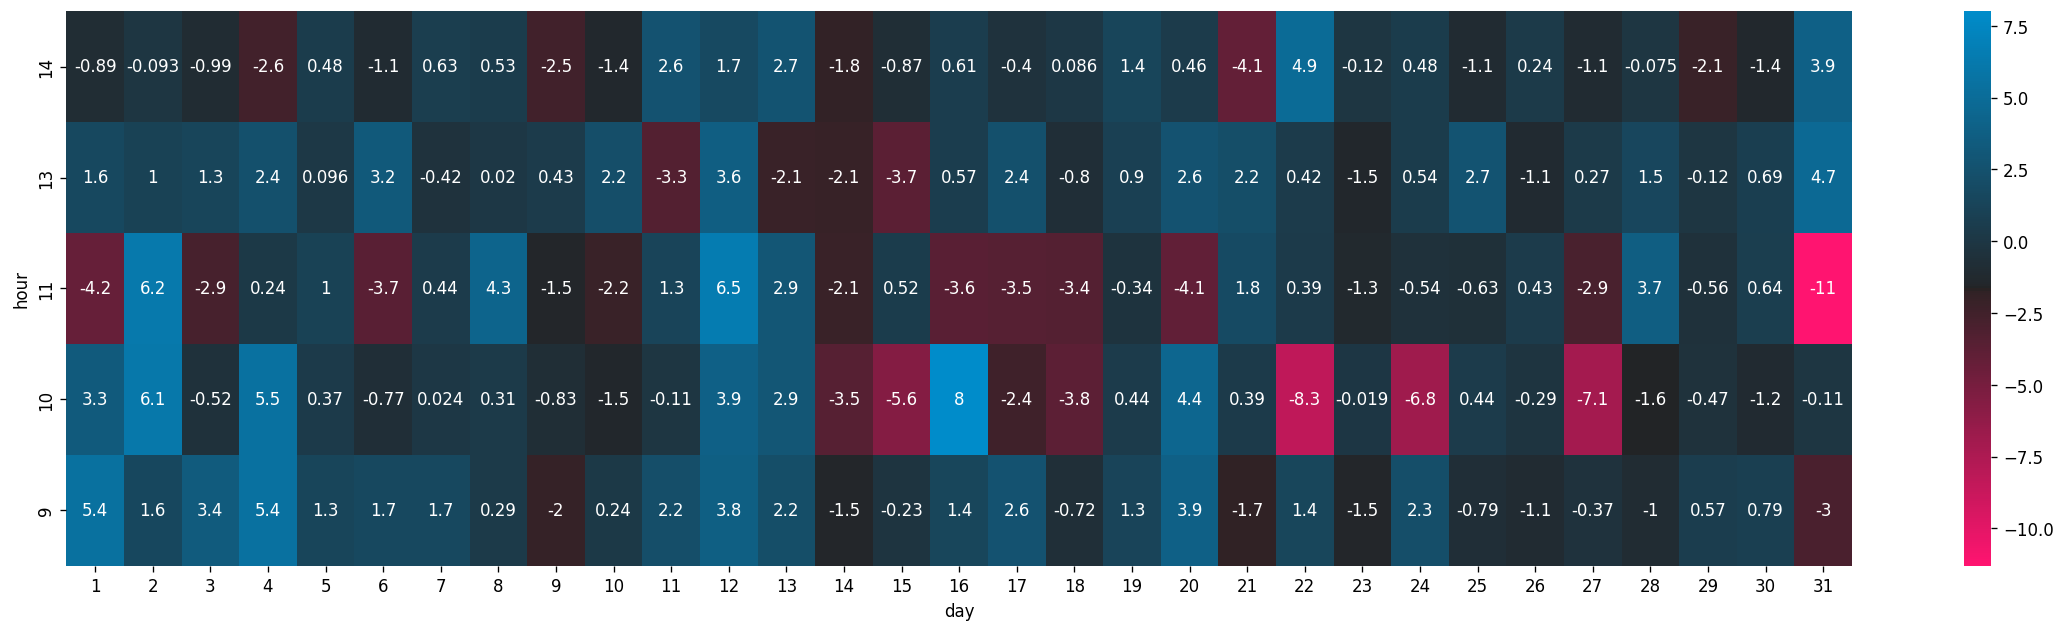

In [32]:
irs2 = long_return.mean().reset_index()
irs_pivot2 = irs2.pivot(index='hour', columns='day', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot2,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

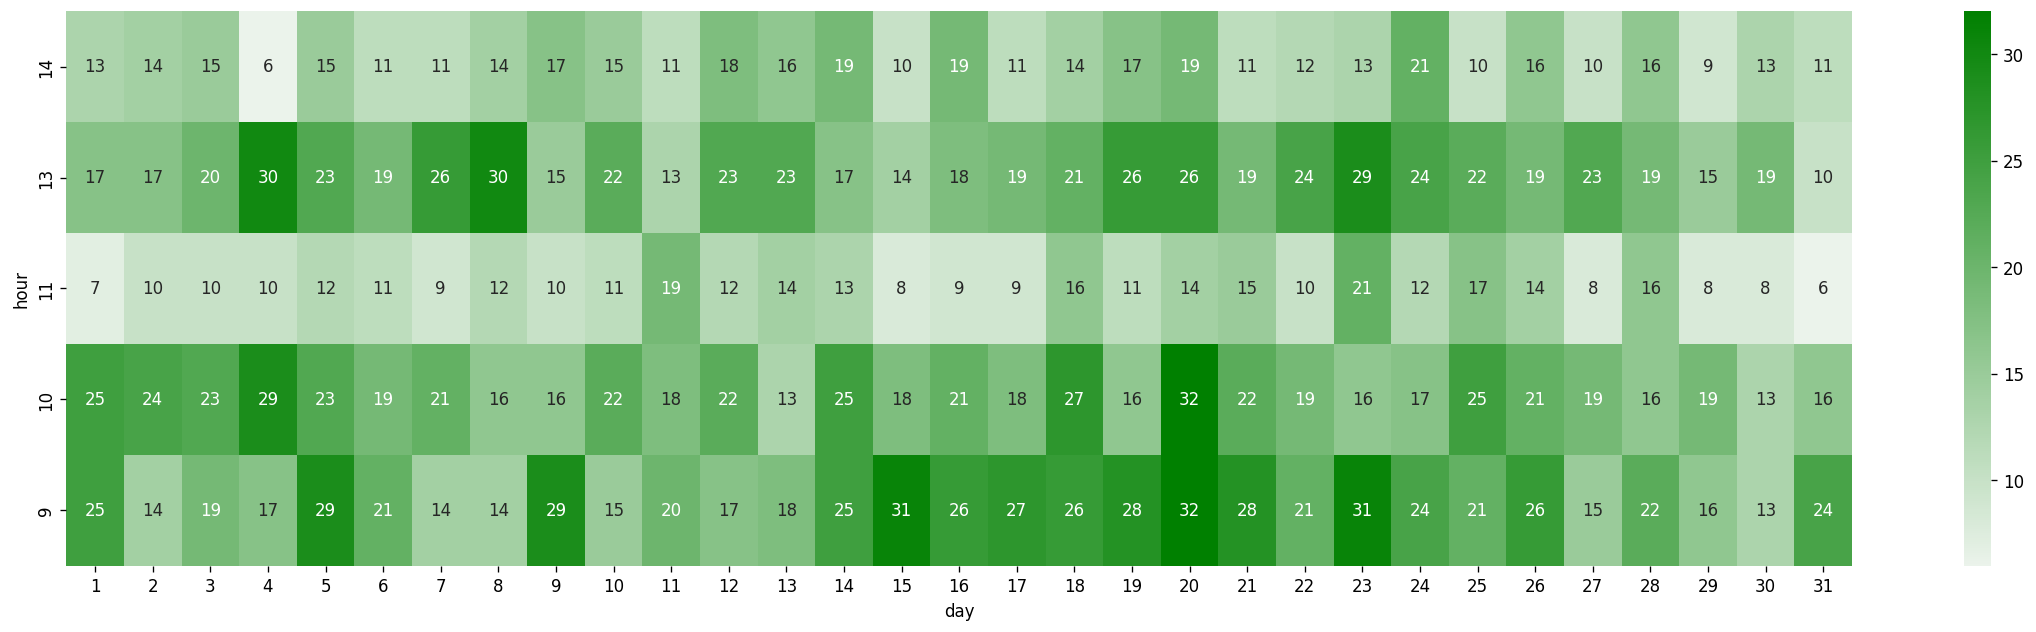

In [34]:
irs3 = long_return.count().reset_index()
irs_pivot3 = irs3.pivot(index='hour', columns='day', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot3,
    cmap = sns.light_palette("green", n_colors=100, reverse=False, as_cmap=True),
    annot=True);

### Phân tích mối quan hệ Risk/Reward và ATR & RSI

In [10]:
df1 = data[["Open", "Close", "High", "Low", "fit", "risk", "reward"]].copy()
df1["risk"] = df1["risk"].astype(float)
df1["reward"] = df1["reward"].astype(float)
df1["return"] = df1["reward"] - df1["risk"]
df1["RSI_14"] = ta.rsi(df1["Close"], length=14)
df1["ATR_14"] = ta.atr(high=df1["High"], low=df1["Low"], close=df1["Close"], length=14)
df1.dropna(inplace=True)
df1["RSI_14"] = round(df1["RSI_14"], 1)
df1["ATR_14"] = round(df1["ATR_14"], 1)
df1['rsi_group'] = pd.qcut(df1.RSI_14, 20)
df1['atr_group'] = pd.qcut(df1.ATR_14, 20)

In [11]:
df1_fit = df1[df1.fit==True]
long_risk = df1_fit.groupby(['rsi_group', 'atr_group'])[['risk']]
long_reward = df1_fit.groupby(['rsi_group', 'atr_group'])[['reward']]
long_return = df1_fit.groupby(['rsi_group', 'atr_group'])[['return']]

In [30]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

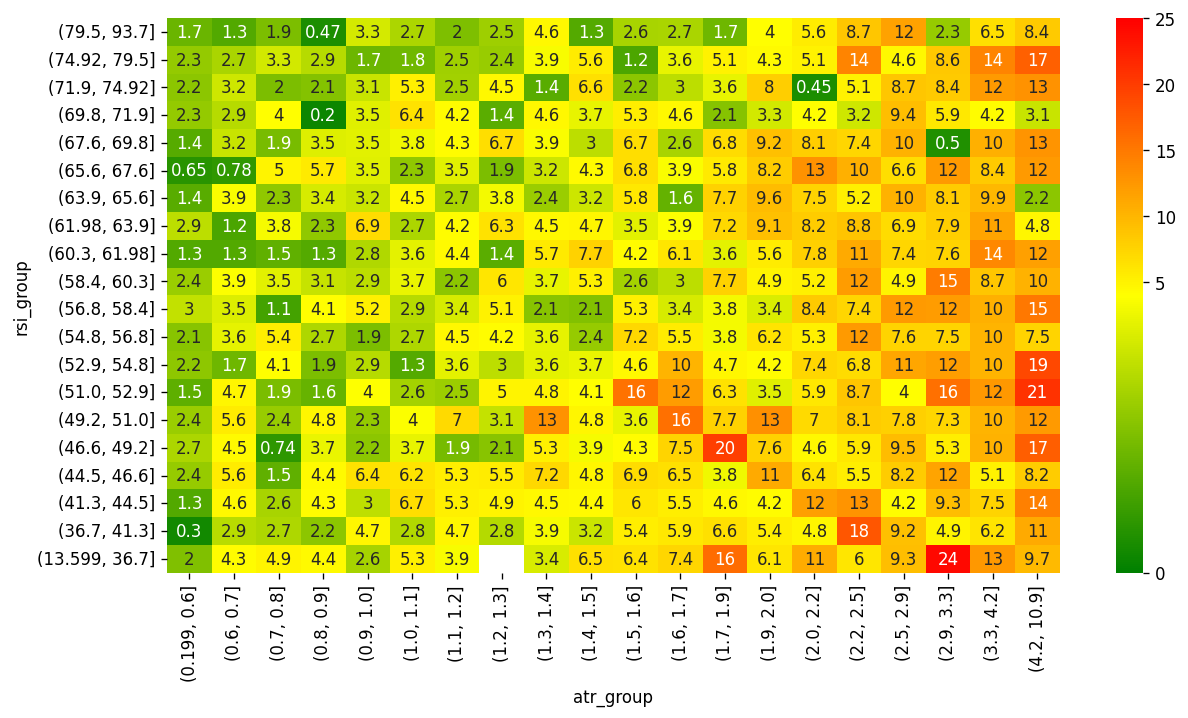

In [13]:
irs1 = long_risk.mean().reset_index()
irs_pivot1 = irs1.pivot(index='rsi_group', columns='atr_group', values='risk').sort_index(ascending=False)
sns.heatmap(
    irs_pivot1,
    cmap=LinearSegmentedColormap.from_list("green_to_red", ["green", "yellow", "red"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=25),
    annot=True);

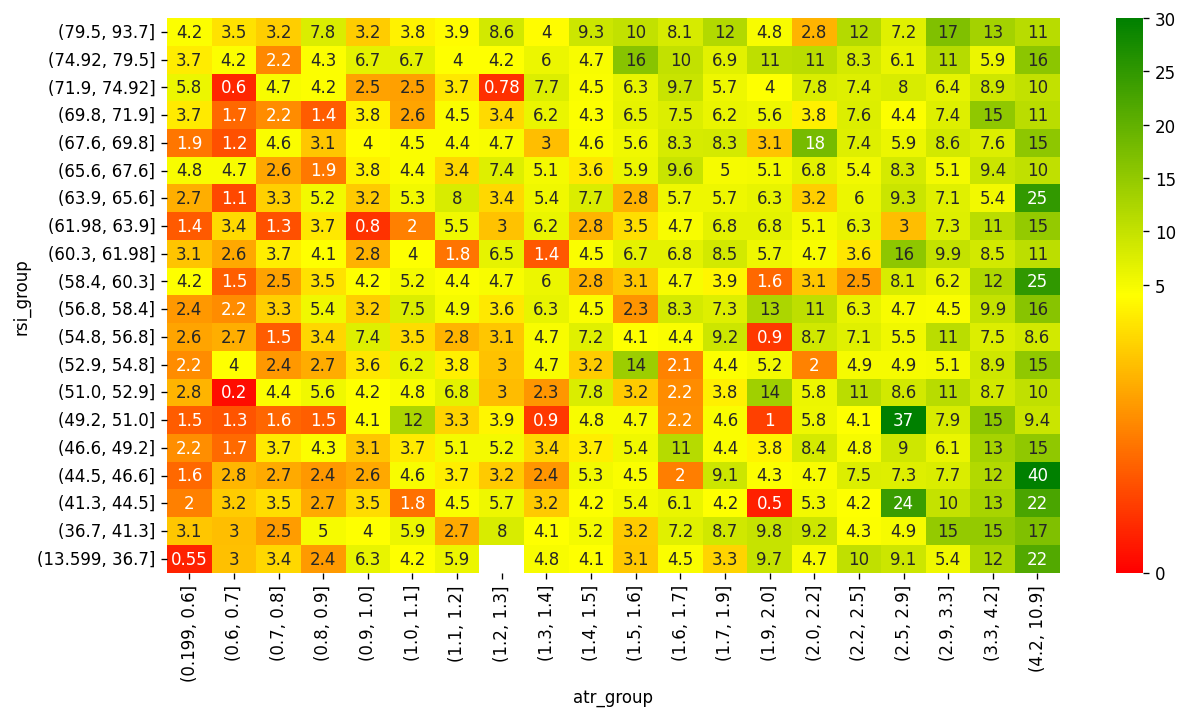

In [14]:
irs2 = long_reward.mean().reset_index()
irs_pivot2 = irs2.pivot(index='rsi_group', columns='atr_group', values='reward').sort_index(ascending=False)
sns.heatmap(
    irs_pivot2,
    cmap=LinearSegmentedColormap.from_list("red_to_green", ["red", "yellow", "green"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=30),
    annot=True);

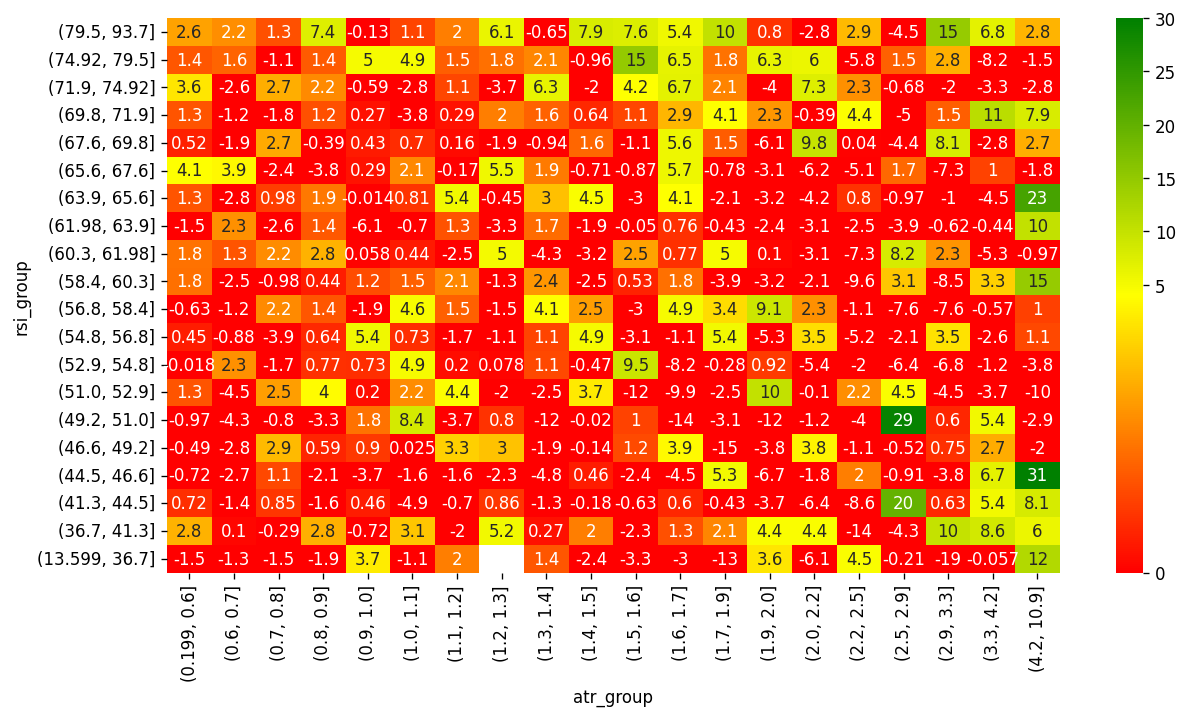

In [15]:
irs3 = long_return.mean().reset_index()
irs_pivot3 = irs3.pivot(index='rsi_group', columns='atr_group', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot3,
    cmap=LinearSegmentedColormap.from_list("red_to_green", ["red", "yellow", "green"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=30),
    annot=True);